In [2]:
import os
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

## 데이터 준비

In [4]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete0H7VOT/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete0H7VOT/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


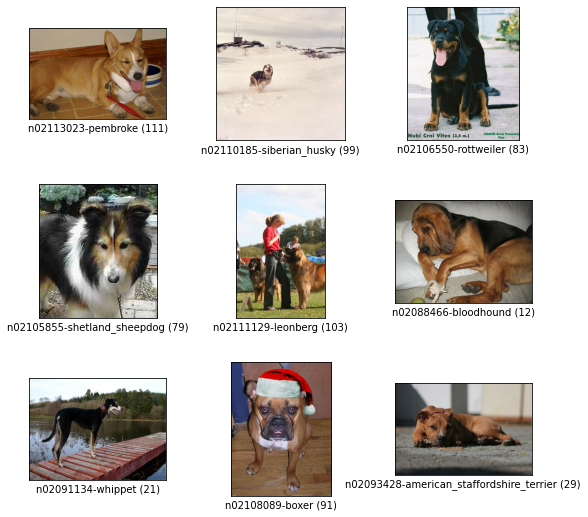

In [5]:
ex_train = tfds.show_examples(ds_train, ds_info)

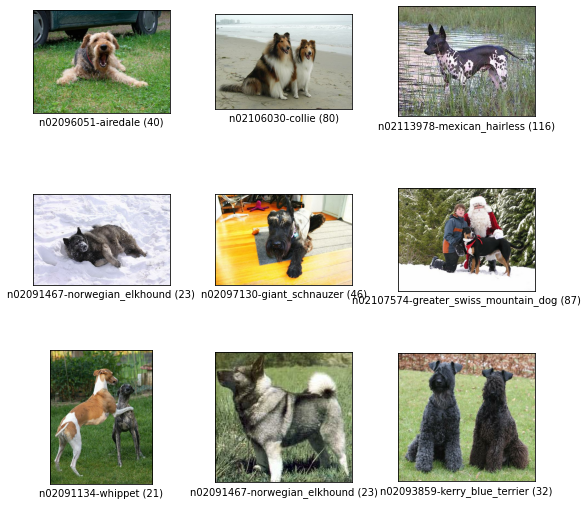

In [6]:
ex_test = tfds.show_examples(ds_test, ds_info)

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [8]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


## CAM 구현하기

CAM 모델은 마지막 fully connected layer 대신 GAP을 사용해주어야 합니다. 

In [10]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 0s 0us/step


In [11]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

### CAM 모델 학습

In [50]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 101s 124ms/step - loss: 0.6468 - accuracy: 0.8279 - val_loss: 1.1080 - val_accuracy: 0.6809
Epoch 2/15
750/750 [==============================] - 92s 123ms/step - loss: 0.2455 - accuracy: 0.9481 - val_loss: 0.9911 - val_accuracy: 0.7126
Epoch 3/15
750/750 [==============================] - 92s 123ms/step - loss: 0.0639 - accuracy: 0.9936 - val_loss: 0.9327 - val_accuracy: 0.7264
Epoch 4/15
750/750 [==============================] - 93s 123ms/step - loss: 0.0314 - accuracy: 0.9981 - val_loss: 0.9615 - val_accuracy: 0.7243
Epoch 5/15
750/750 [==============================] - 93s 124ms/step - loss: 0.0299 - accuracy: 0.9980 - val_loss: 0.9705 - val_accuracy: 0.7297
Epoch 6/15
750/750 [==============================] - 93s 124ms/step - loss: 0.0117 - accuracy: 0.9995 - val_loss: 0.9449 - val_accuracy: 0.7347
Epoch 7/15
750/750 [==============================] - 93s 124ms/step - loss: 0.0070 - accuracy: 0.9999 - val_loss: 0.9718 - val_accuracy: 0.

- CAM생성을 위해 모델의 가중치를 저장 합니다

In [51]:
cam_model_path = 'cam_model1.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


### Class Activation Map 생성
CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, get_one() 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 합니다.

In [52]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

67


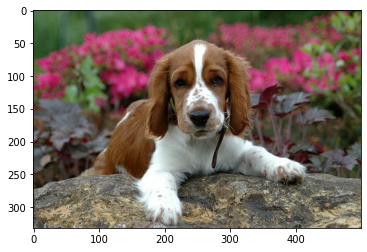

In [53]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

- 이제 데이터가 준비되었으니 CAM을 생성하기 위해 미리 준비된 학습한 모델을 불러옵니다.

In [54]:
cam_model_path = 'cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

- CAM을 생성하기 위해서는 **특성 맵, 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치, 원하는 클래스의 출력값**이 필요합니다. 또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화해야 할 것입니다. 이를 고려해서 `model`과 `item`을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 합니다.

- `generate_cam()` 을 구현하기 위해 아래에서는 `conv_ouputs`와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현하였습니다. 마지막에는 입력 이미지의 크기에 맞춰 CAM을 `resize`해줍니다.

In [55]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

- 위에서 작성한 함수를 실행하면 아래와 같은 CAM을 얻을 수 있습니다.

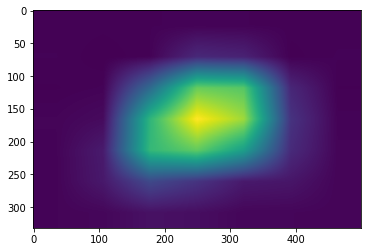

In [56]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

- 이렇게 그려진 CAM 이미지를 `visualize_cam_on_image`을 통해 원본 이미지와 합쳐 볼 수 있습니다.

In [57]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

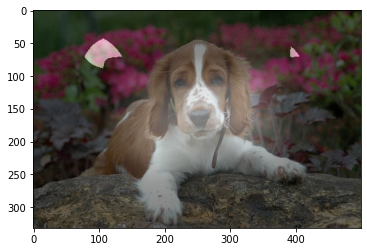

In [58]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## Grad-CAM 구현하기
- 적용 모델을 유연하게 선택할 수 있는 Grad-CAM의 특성 상 위에서 만들었던 모델을 다시 활용해도 괜찮기 때문에 관찰 대상 모델은 `cam_model`을 그대로 활용합니다.

67


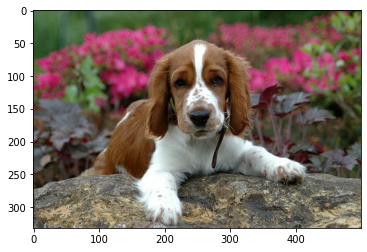

In [91]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

- `grad_cam`은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구합니다. 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(`weights`)와 레이어에서 나온 채널별 특성 맵을 가중합해주어 `cam_image`를 얻게 됩니다.


아래 `generate_grad_cam()`에서는 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 `grad_val`을 얻고 이를 `weights`로 활용합니다.

In [92]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

`visualize_result`를 통해 여러 레이어의 CAM 이미지를 뽑아 확인해 볼 수 있습니다. <br>
레이어의 이름은 이전 스탭의 `cam_model.summary()` 결과에서 찾을 수 있습니다.

In [93]:
def visualize_result(blockname):
  grad_cam_image = generate_grad_cam(cam_model, blockname, item)

  origin_image = item['image'].astype(np.uint8)
  grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
  blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)

  plt.figure(figsize=(15,30))
  plt.subplot(1,2,1)
  plt.title('CAM image')
  plt.imshow(grad_cam_image)

  plt.subplot(1,2,2)
  plt.title('visualize CAM on image')
  plt.imshow(blended_image)
  plt.show()

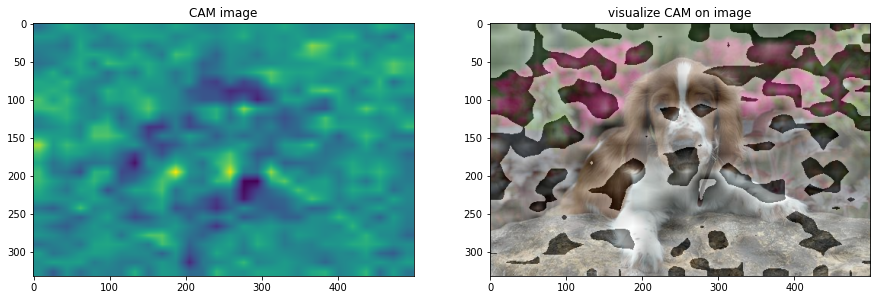

In [94]:
visualize_result('conv3_block3_out')

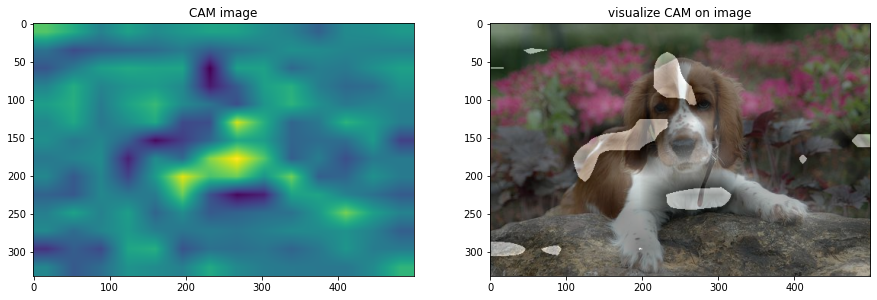

In [95]:
visualize_result('conv4_block3_out')

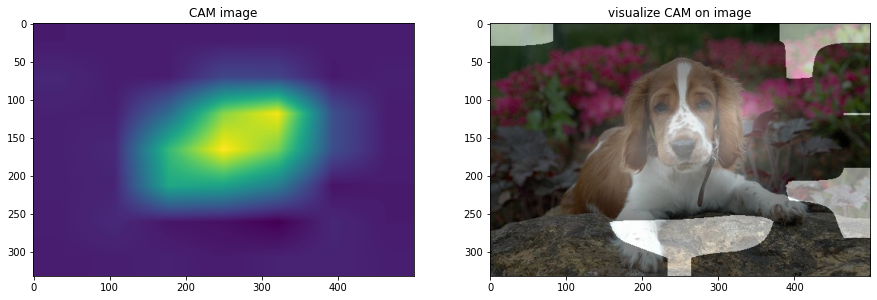

In [96]:
visualize_result('conv5_block3_out')

## 바운딩 박스 구하기
우선 비교를 위해 새로운 이미지를 불러와 CAM과 grad_CAM의 결과를 만듭니다.

67


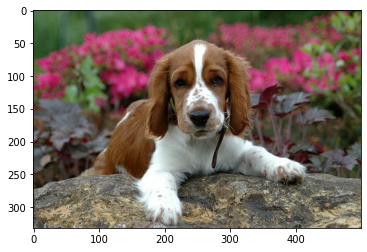

In [76]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

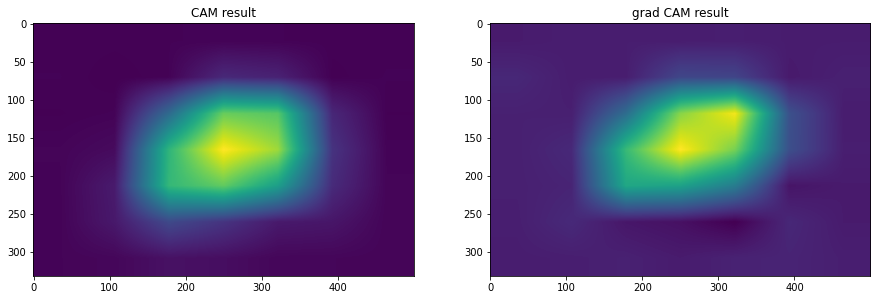

In [77]:
cam_image = generate_cam(cam_model, item)
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out',item)

plt.figure(figsize=(15,30))
plt.subplot(1,2,1)
plt.imshow(cam_image)
plt.title('CAM result')

plt.subplot(1,2,2)
plt.imshow(grad_cam_image)
plt.title('grad CAM result')

plt.show()

`get_bbox()` 함수로 바운딩 박스를 만들기 위해서 `score_thresh`를 받아 역치값 이하의 바운딩 박스는 없앱니다. 그 다음 OpenCV의 `findContours()`와 `minAreaRect()`로 사각형을 찾습니다. 이때 `rotated_rect` 라는 회전된 바운딩 박스를 얻을 수 있습니다. `boxPoints()`로 이를 꼭지점으로 바꾸어 줍니다. 마지막에는 `int` 자료형으로 변환해 줍니다.

In [78]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [79]:
rect1 = get_bbox(cam_image)
rect2 = get_bbox(grad_cam_image)
rect1

array([[115, 336],
       [ 51,  99],
       [397,   4],
       [462, 242]])

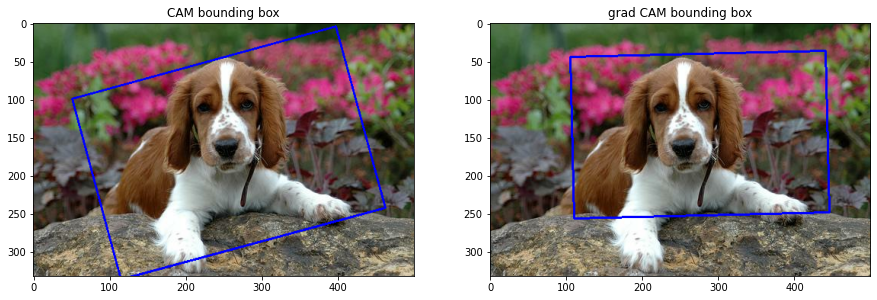

In [80]:
image1 = copy.deepcopy(item['image'])
image1 = cv2.drawContours(image1, [rect1], 0, (0,0,255), 2)
image2 = copy.deepcopy(item['image'])
image2 = cv2.drawContours(image2, [rect2], 0, (0,0,255), 2)

plt.figure(figsize=(15,30))
plt.subplot(1,2,1)
plt.imshow(image1)
plt.title('CAM bounding box')

plt.subplot(1,2,2)
plt.imshow(image2)
plt.title('grad CAM bounding box')
plt.show()

## IoU 구하기
`IoU(Intersection over Union)`는 두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union 영역으로 나누어준 값입니다. 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있으므로, 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 됩니다.

In [81]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

위에서 구했던 `rect`를 `minmax bbox` 형태로 치환해줍니다.

In [82]:
pred_bbox1 = rect_to_minmax(rect1, item['image'])
pred_bbox2 = rect_to_minmax(rect2, item['image'])
pred_bbox1

[0.012048192771084338, 0.102, 1.0120481927710843, 0.924]

In [83]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [84]:
def get_iou(boxA, boxB):  # iou 계산
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [85]:
get_iou(pred_bbox1, item['objects']['bbox'][0])

0.7051563756019239

In [86]:
get_iou(pred_bbox2, item['objects']['bbox'][0])

0.6129092826939376

---
## 회고
ㅁ